In [1]:
import pandas as pd 
import numba
import seaborn as sns 
import matplotlib.pyplot as plt
import geopandas as gpd
import palettable as pltt
import descartes
from pysal.viz import mapclassify 
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib_scalebar.scalebar import ScaleBar

# Import datasets

In [2]:
Bradford = gpd.read_file('Bradford_data.csv') #shapefile containing IMD data
comcenter = pd.read_csv('Community_Center.csv') #community center data

In [3]:
Assets = pd.read_csv('Bradford_Community Assets.csv')

In [4]:
#convert data to shapefile
comcenter = gpd.GeoDataFrame(comcenter, geometry=gpd.points_from_xy(comcenter['longitude'], comcenter['latitude']))

In [5]:
Assets = gpd.GeoDataFrame(Assets, geometry=gpd.points_from_xy(Assets['longitude'], Assets['latitude']))

In [6]:
del Bradford['wkt']

In [7]:
Bradford.head()

,LSOA,lsoa11nm,Male,Female,Africa,Antartica and Oceania,Middle East and Asia,America and Caribbean,Europe,Minority_percentage,United Kingdom,IMD_Rank,IMDScore,Health_Rank,Health_Score,TotPop,st_areasha,geometry
0,E01010646,Bradford 001A,609.00,739.00,6.00,2.00,6.00,5.00,13.00,2.48,1317.00,29901.00,5.60,21504.00,-0.35,1290.00,11278747.40,"POLYGON ((407989.096 451026.306, 408046.002 45..."
1,E01010647,Bradford 001B,500.00,557.00,5.00,3.00,5.00,9.00,25.00,4.47,1009.00,22949.00,11.33,10070.00,0.42,1051.00,897799.13,"POLYGON ((407589.824 450708.810, 407701.534 45..."
2,E01010648,Bradford 001C,658.00,721.00,5.00,6.00,7.00,6.00,31.00,4.22,1326.00,30451.00,5.06,21563.00,-0.36,1302.00,811308.60,"POLYGON ((406639.781 450328.682, 406821.197 45..."
3,E01010692,Bradford 001D,904.00,1013.00,12.00,10.00,22.00,10.00,60.00,6.15,1801.00,28120.00,7.16,23468.00,-0.50,1853.00,11613366.49,"POLYGON ((410796.176 448371.114, 410788.038 44..."
4,E01010691,Bradford 002A,754.00,822.00,0.00,2.00,15.00,6.00,41.00,3.96,1511.00,31769.00,3.68,23644.00,-0.52,1618.00,725492.09,"POLYGON ((412356.398 447798.267, 412386.932 44..."


<AxesSubplot:>

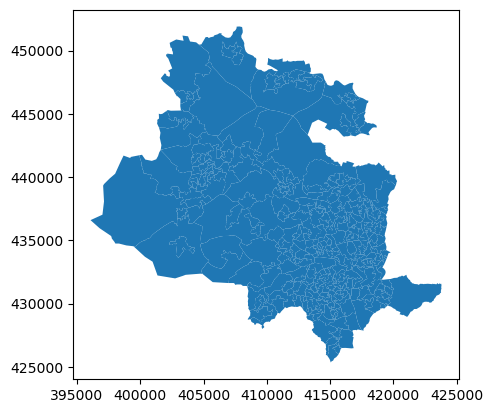

In [8]:
Bradford.plot()

<AxesSubplot:>

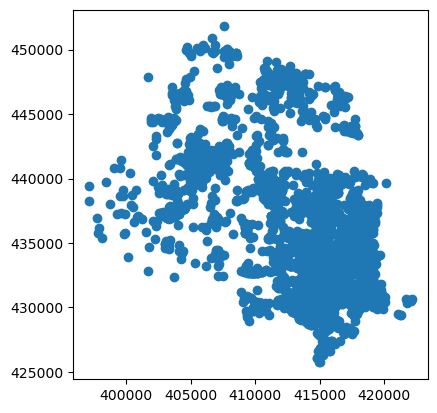

In [9]:
Assets.plot()

# Create Map

In [10]:
def CreateMap(polygon, point):
    fig, ax = plt.subplots(1,1, figsize=(8,8), ) #set the figure size
    polygon.plot(ax = ax, facecolor = '#EDBB8A', edgecolor = 'white', linewidth = 0.2) #plot the Leeds map, specifying the colour and linewidth
    point.plot(ax = ax, color = '#008080', linewidth = 0.5, alpha = 0.2) #plot the bus stations
    ax.set_axis_off() #remove axes
    fig.suptitle('Outline of Bradford') # add a title
    return plt.show() 

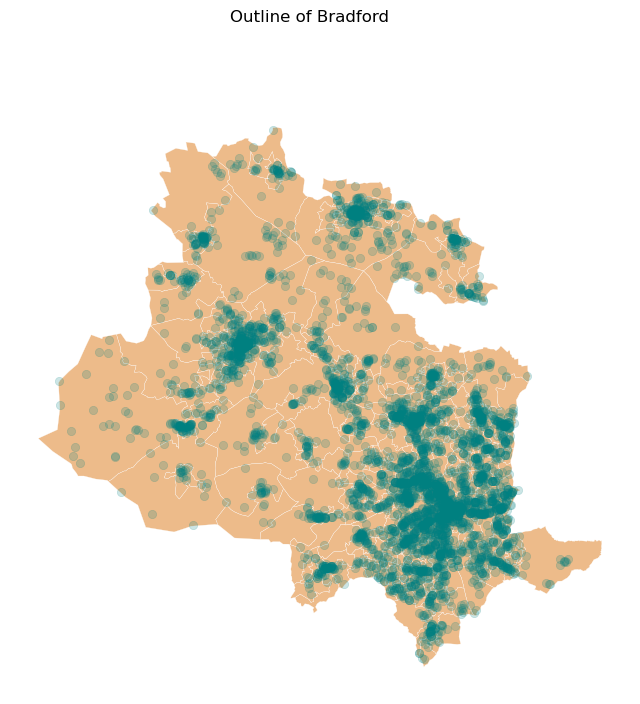

In [11]:
CreateMap(Bradford, Assets)

# Create Subset

In [12]:
def CreateSub(df, Category, sub):
    sub = df[df[Category] == sub].reset_index(drop = True)
    return sub

In [13]:
set(Assets['Community Assets'].values)

{'Arts Center, Culture, Heritage',
 'Cafes',
 'Community Centers, Social Club',
 'Community Organisations, Volunteer Groups',
 'Education Center',
 'Entertainment',
 'Entertainment (Gambling)',
 'Faith Setting',
 'Green/Blue Space',
 'Health Services',
 'Health Services (Care Home)',
 'Library',
 'Restaurant',
 'Wi-Fi Hotspot'}

In [14]:
Heritage = CreateSub(Assets, 'Community Assets', 'Arts Center, Culture, Heritage')
Cafes = CreateSub(Assets, 'Community Assets', 'Cafes')
Com_Center = CreateSub(Assets, 'Community Assets', 'Community Centers, Social Club')
Com_Group = CreateSub(Assets, 'Community Assets', 'Community Organisations, Volunteer Groups')
Education = CreateSub(Assets, 'Community Assets', 'Education Center')
Entertainment = CreateSub(Assets, 'Community Assets', 'Entertainment')
Faith = CreateSub(Assets, 'Community Assets', 'Faith Setting')
Greenspace = CreateSub(Assets, 'Community Assets', 'Green/Blue Space')
Health_Services = CreateSub(Assets, 'Community Assets', 'Health Services')
Library = CreateSub(Assets, 'Community Assets', 'Library')
Restaurant = CreateSub(Assets, 'Community Assets', 'Restaurant')
Wifi = CreateSub(Assets, 'Community Assets', 'Wi-Fi Hotspot')


In [15]:
def CreateColumn(df, sub, column_name):
    pointsInPoly = gpd.sjoin(sub, df, predicate='intersects') 
    pointsInPoly[column_name]=1 
    column_sum = pointsInPoly.groupby(['LSOA']).sum().reset_index() 
    column_sub = column_sum[['LSOA', column_name]]
    return df.join(column_sub.set_index('LSOA'), on = 'LSOA')

In [16]:
def JoinData(df, sub1, sub2, sub3, sub4, total, name1, name2, name3, name4, name5):
    a = CreateColumn(df, sub1, name1)
    b = CreateColumn(a, sub2, name2)
    c = CreateColumn(b, sub3, name3)
    d = CreateColumn(c, sub4, name4)
    e = CreateColumn(d, total, name5)
    e = e.fillna(0)
    e.iloc[:, 2:17] = e.iloc[:, 2:17].astype(float)
    return e

In [17]:
def JoinData3(df, sub1, sub2, sub3, name1, name2, name3):
    a = CreateColumn(df, sub1, name1)
    b = CreateColumn(a, sub2, name2)
    c = CreateColumn(b, sub3, name3)
    c = c.fillna(0)
    c.iloc[:, 2:17] = c.iloc[:, 2:17].astype(float)
    return c

In [18]:
Bradford_all = JoinData(Bradford, Heritage, Cafes, Com_Center, Com_Group, Education, 'Heritage', 'Cafes', 'Com_Center', 'Com_Group', 'Education')

In [19]:
Bradford_all = JoinData(Bradford_all, Entertainment, Faith, Greenspace, Health_Services, Library, 'Entertainment', 'Faith', 'Greenspace', 'Health_Services', 'Library')

In [20]:
Bradford_all = JoinData3(Bradford_all, Restaurant, Wifi, Assets, 'Restaurant', 'Wifi', 'Total Community Assets')

In [21]:
Bradford_all.head()

,LSOA,lsoa11nm,Male,Female,Africa,Antartica and Oceania,Middle East and Asia,America and Caribbean,Europe,Minority_percentage,...,Com_Group,Education,Entertainment,Faith,Greenspace,Health_Services,Library,Restaurant,Wifi,Total Community Assets
0,E01010646,Bradford 001A,609.0,739.0,6.0,2.0,6.0,5.0,13.0,2.48,...,0.0,0.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,25.0
1,E01010647,Bradford 001B,500.0,557.0,5.0,3.0,5.0,9.0,25.0,4.47,...,1.0,4.0,0.0,1.0,1.0,3.0,1.0,2.0,0.0,19.0
2,E01010648,Bradford 001C,658.0,721.0,5.0,6.0,7.0,6.0,31.0,4.22,...,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,7.0
3,E01010692,Bradford 001D,904.0,1013.0,12.0,10.0,22.0,10.0,60.0,6.15,...,1.0,4.0,3.0,1.0,10.0,8.0,1.0,5.0,4.0,90.0
4,E01010691,Bradford 002A,754.0,822.0,0.0,2.0,15.0,6.0,41.0,3.96,...,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,5.0


In [22]:
def CreateChoro(df, column, colour):
    fig, ax = plt.subplots(1) 
    df.plot(ax = ax,column = column, scheme='equalinterval', cmap = colour, edgecolor = 'Black', k = 5, linewidth=0.5,legend = True) 
    plt.title('Choropleth of ' + column + ' in Bradford') 
    leg = ax.get_legend() 
    leg.set_bbox_to_anchor((1.4,0.5)) 
    ax.set_axis_off() 
    plt.show() 

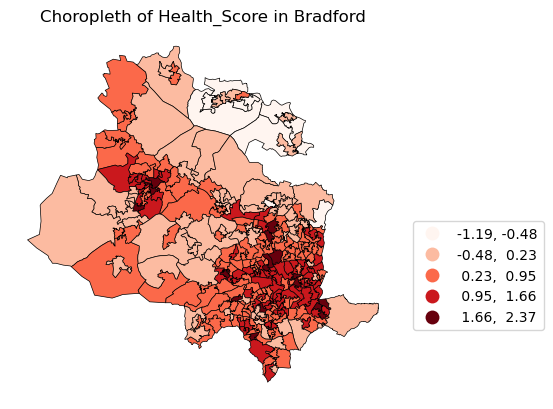

In [23]:
CreateChoro(Bradford_all,'Health_Score', 'Reds')

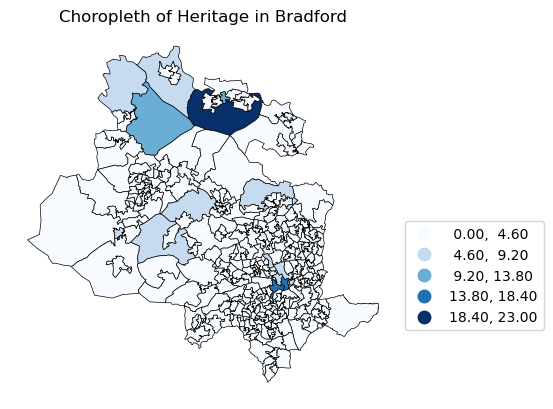

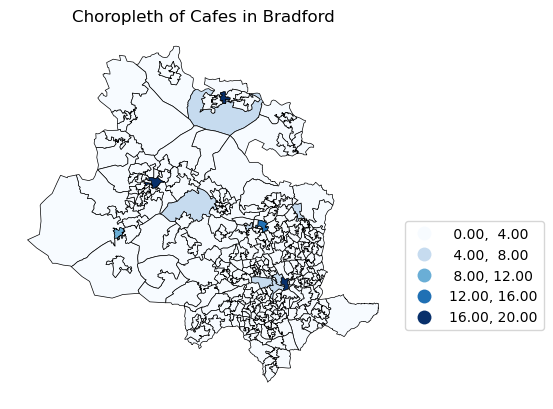

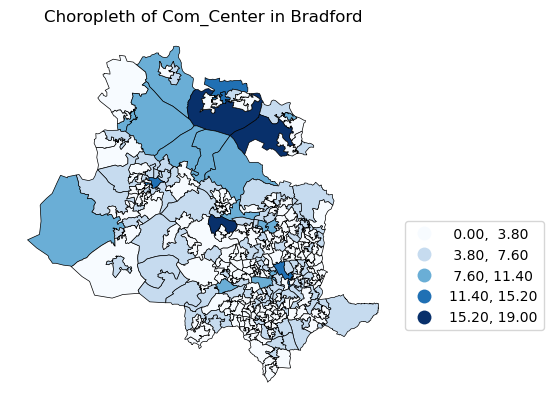

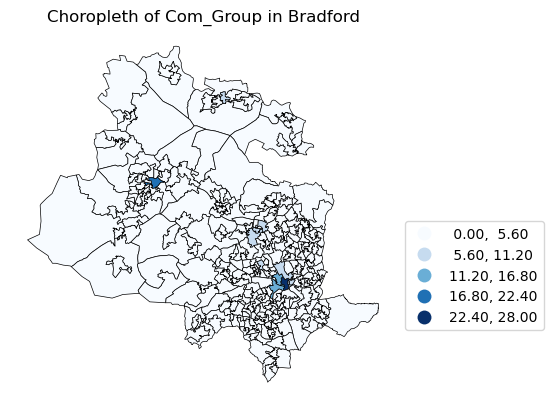

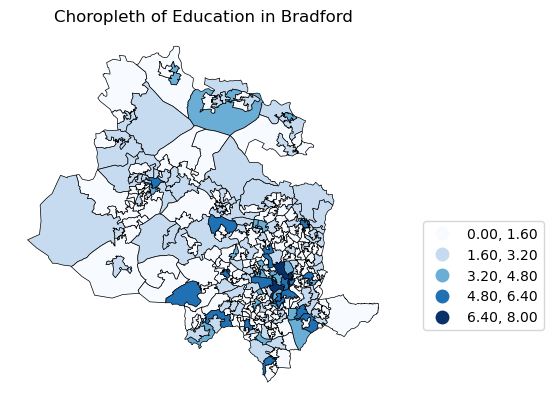

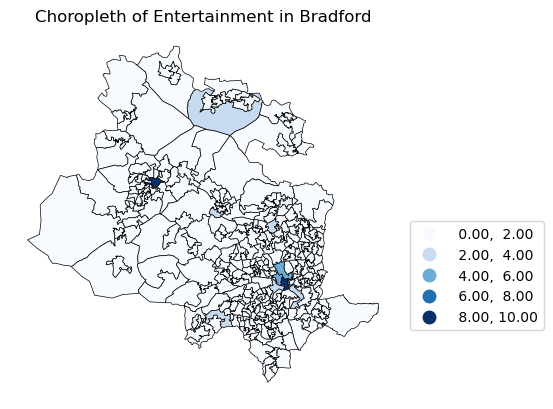

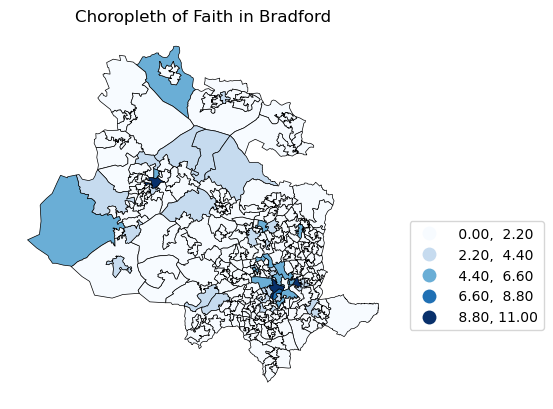

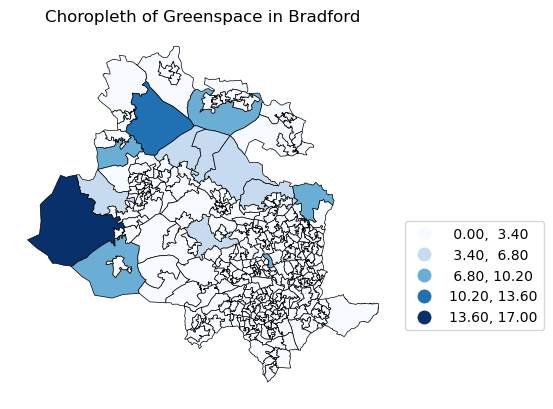

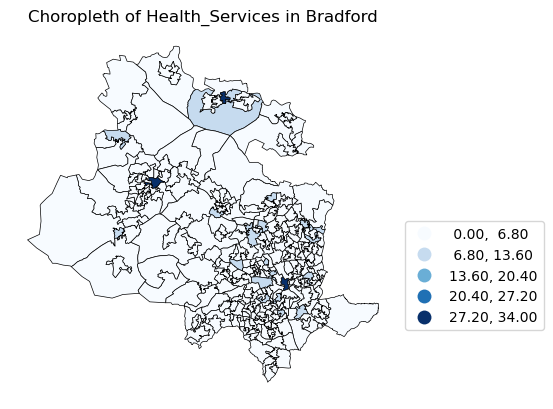

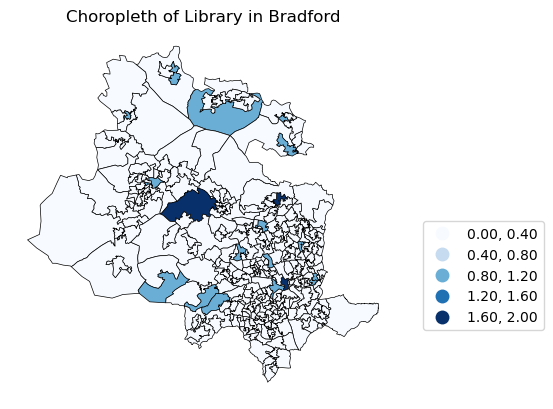

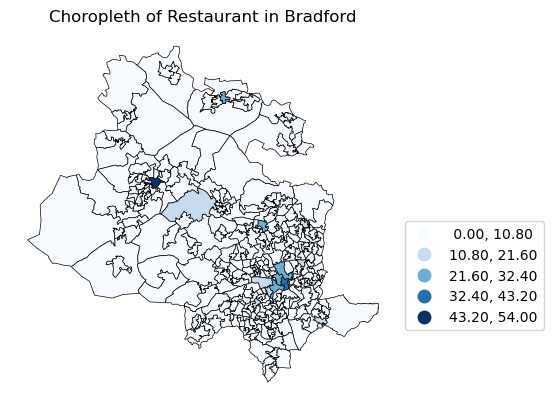

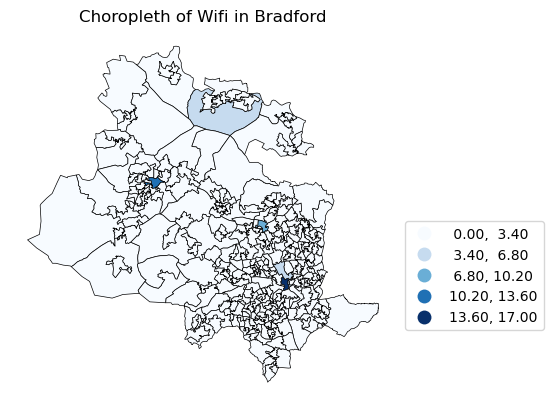

In [24]:
CreateChoro(Bradford_all,'Heritage', 'Blues')
CreateChoro(Bradford_all,'Cafes', 'Blues')
CreateChoro(Bradford_all,'Com_Center', 'Blues')
CreateChoro(Bradford_all,'Com_Group', 'Blues')
CreateChoro(Bradford_all,'Education', 'Blues')
CreateChoro(Bradford_all,'Entertainment', 'Blues')
CreateChoro(Bradford_all,'Faith', 'Blues')
CreateChoro(Bradford_all,'Greenspace', 'Blues')
CreateChoro(Bradford_all,'Health_Services', 'Blues')
CreateChoro(Bradford_all,'Library', 'Blues')
CreateChoro(Bradford_all,'Restaurant', 'Blues')
CreateChoro(Bradford_all,'Wifi', 'Blues')

# Correlation

In [25]:
Bradford_all.columns

Index(['LSOA', 'lsoa11nm', 'Male', 'Female', 'Africa', 'Antartica and Oceania',
       'Middle East and Asia', 'America and Caribbean', 'Europe',
       'Minority_percentage', 'United Kingdom', 'IMD_Rank', 'IMDScore',
       'Health_Rank', 'Health_Score', 'TotPop', 'st_areasha', 'geometry',
       'Heritage', 'Cafes', 'Com_Center', 'Com_Group', 'Education',
       'Entertainment', 'Faith', 'Greenspace', 'Health_Services', 'Library',
       'Restaurant', 'Wifi', 'Total Community Assets'],
      dtype='object')

In [26]:
a = Bradford_all.corr()
a.iloc[[12], -13:-1]

,Heritage,Cafes,Com_Center,Com_Group,Education,Entertainment,Faith,Greenspace,Health_Services,Library,Restaurant,Wifi
Health_Score,-0.128822,0.084645,-0.041221,0.134945,0.183805,0.113452,0.18624,-0.200584,0.051716,-0.008088,0.231154,0.04747


In [27]:
a.iloc[[10], -13:-1]

,Heritage,Cafes,Com_Center,Com_Group,Education,Entertainment,Faith,Greenspace,Health_Services,Library,Restaurant,Wifi
IMDScore,-0.153576,0.06289,-0.037236,0.125593,0.156778,0.104809,0.175565,-0.232508,0.064152,-0.059814,0.241835,0.047813


# Regression

In [28]:
y = Bradford_all['Health_Score']  # set the y variable
X = Bradford_all[['Education', 'Faith', 'Greenspace']] 
x1 = sm.add_constant(X) # add a constant to X
ITSmod = sm.OLS(y, x1) # create an OLS regression model
results = ITSmod.fit() # fit the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Health_Score   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     11.71
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           2.78e-07
Time:                        21:52:58   Log-Likelihood:                -262.00
No. Observations:                 310   AIC:                             532.0
Df Residuals:                     306   BIC:                             546.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5056      0.050     10.079      0.000       0.407       0.604
Education      0.0576      0.022      2.663      0.008       0.015       0.100
Faith          0.0570      0.021      2.745      0.006       0.016       0.098
Greenspace    -0.0763      0.018     -4.177      0.000      -0.112      -0.040
==============================================================================
Omnibus:                        0.001   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.999   Jarque-Bera (JB):                0.039
Skew:                          -0.005   Prob(JB):                        0.981
Kurtosis:                       2.946   Cond. No.                         4.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
Bradford_all.to_csv('Bradford_raw.csv', index = False)

# Community Centers

In [30]:
set(comcenter['Category'].values)

{'Community Center', 'Playground', 'Social Club', 'Sports Center'}

In [31]:
Community_Center = CreateSub(comcenter, 'Category', 'Community Center')
Playground = CreateSub(comcenter, 'Category', 'Playground')
Social_Club = CreateSub(comcenter, 'Category', 'Social Club')
Sports_Center = CreateSub(comcenter, 'Category', 'Sports Center')

In [32]:
Bradford_new = JoinData(Bradford, Sports_Center, Playground, Community_Center, Social_Club, comcenter, 'Sport Centers', 'Playgrounds', 'Community Centers', 'Social Clubs', 'Total Community Assets')
Bradford_new.head()

,LSOA,lsoa11nm,Male,Female,Africa,Antartica and Oceania,Middle East and Asia,America and Caribbean,Europe,Minority_percentage,...,Health_Rank,Health_Score,TotPop,st_areasha,geometry,Sport Centers,Playgrounds,Community Centers,Social Clubs,Total Community Assets
0,E01010646,Bradford 001A,609.0,739.0,6.0,2.0,6.0,5.0,13.0,2.48,...,21504.0,-0.35,1290.0,11278747.40,"POLYGON ((407989.096 451026.306, 408046.002 45...",9.0,0.0,1.0,0.0,10.0
1,E01010647,Bradford 001B,500.0,557.0,5.0,3.0,5.0,9.0,25.0,4.47,...,10070.0,0.42,1051.0,897799.13,"POLYGON ((407589.824 450708.810, 407701.534 45...",2.0,2.0,1.0,1.0,6.0
2,E01010648,Bradford 001C,658.0,721.0,5.0,6.0,7.0,6.0,31.0,4.22,...,21563.0,-0.36,1302.0,811308.60,"POLYGON ((406639.781 450328.682, 406821.197 45...",1.0,1.0,0.0,0.0,2.0
3,E01010692,Bradford 001D,904.0,1013.0,12.0,10.0,22.0,10.0,60.0,6.15,...,23468.0,-0.50,1853.0,11613366.49,"POLYGON ((410796.176 448371.114, 410788.038 44...",18.0,0.0,0.0,0.0,18.0
4,E01010691,Bradford 002A,754.0,822.0,0.0,2.0,15.0,6.0,41.0,3.96,...,23644.0,-0.52,1618.0,725492.09,"POLYGON ((412356.398 447798.267, 412386.932 44...",0.0,0.0,1.0,0.0,1.0


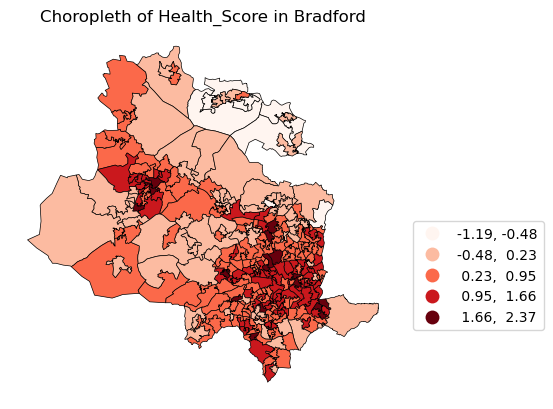

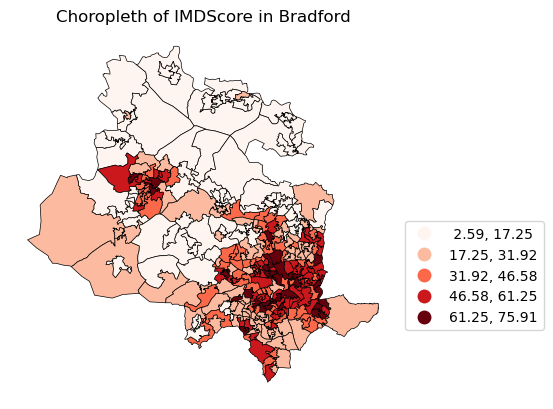

In [33]:
CreateChoro(Bradford_new,'Health_Score', 'Reds')
CreateChoro(Bradford_new,'IMDScore', 'Reds')

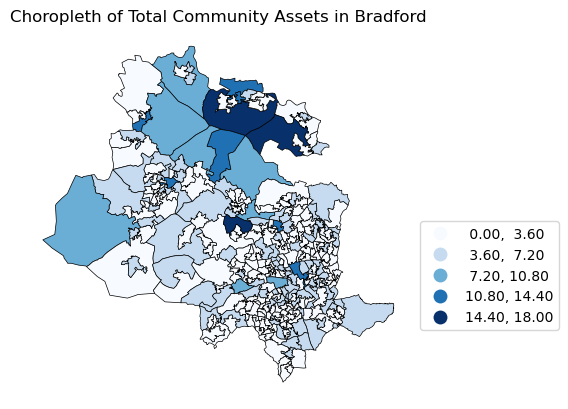

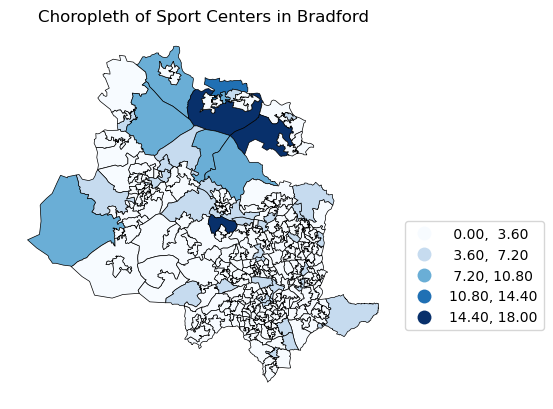

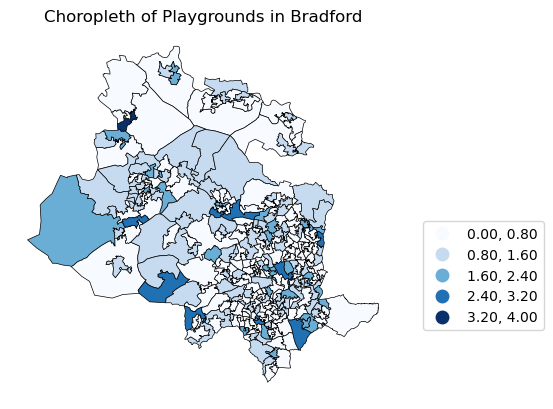

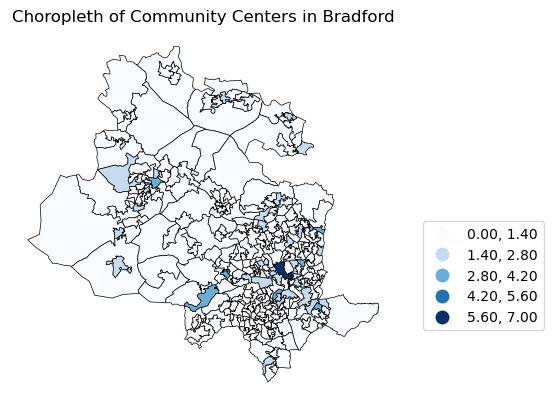

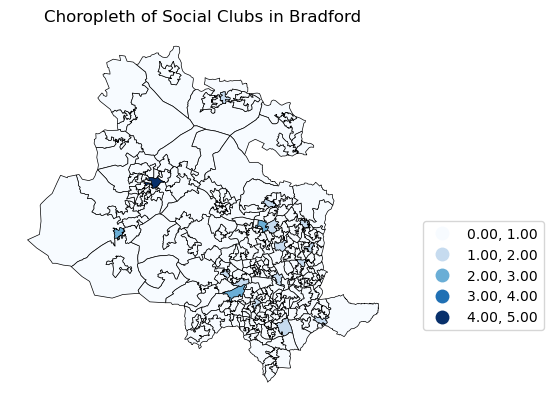

In [34]:
CreateChoro(Bradford_new,'Total Community Assets', 'Blues')
CreateChoro(Bradford_new,'Sport Centers', 'Blues')
CreateChoro(Bradford_new,'Playgrounds', 'Blues')
CreateChoro(Bradford_new,'Community Centers', 'Blues')
CreateChoro(Bradford_new,'Social Clubs', 'Blues')

In [35]:
b = Bradford_new.corr()
b.iloc[[12], -5:-1]

,Sport Centers,Playgrounds,Community Centers,Social Clubs
Health_Score,-0.240631,0.12859,0.300605,0.028193


In [36]:
Bradford_new.to_csv('Bradford_new.csv', index = False)

In [37]:
Bradford_ratio = gpd.read_file('Bradford_all.csv')
Bradford_ratio.head()

,LSOA,lsoa11nm,Male,Female,Africa,Antartica and Oceania,Middle East and Asia,America and Caribbean,Europe,Minority_percentage,...,Greenspace,Library,Sport Centers,Total Community Assets,r_heritage,r_greenspace,r_library,r_sports,r_total,geometry
0,E01010646,Bradford 001A,609,739,6,2,6,5,13,2.48,...,2,0,9,19,161.25,645.00,0.00,143.33,67.89,"POLYGON ((407989.096 451026.306, 408046.002 45..."
1,E01010647,Bradford 001B,500,557,5,3,5,9,25,4.47,...,1,1,2,4,0.00,1051.00,1051.00,525.50,262.75,"POLYGON ((407589.824 450708.810, 407701.534 45..."
2,E01010648,Bradford 001C,658,721,5,6,7,6,31,4.22,...,2,0,1,3,0.00,651.00,0.00,1302.00,434.00,"POLYGON ((406639.781 450328.682, 406821.197 45..."
3,E01010692,Bradford 001D,904,1013,12,10,22,10,60,6.15,...,10,1,18,52,80.57,185.30,1853.00,102.94,35.63,"POLYGON ((410796.176 448371.114, 410788.038 44..."
4,E01010691,Bradford 002A,754,822,0,2,15,6,41,3.96,...,1,0,0,1,0.00,1618.00,0.00,0.00,1618.00,"POLYGON ((412356.398 447798.267, 412386.932 44..."


In [38]:
del Bradford_ratio['wkt']

In [39]:
Bradford_ratio.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   LSOA                    310 non-null    object  
 1   lsoa11nm                310 non-null    object  
 2   Male                    310 non-null    object  
 3   Female                  310 non-null    object  
 4   Africa                  310 non-null    object  
 5   Antartica and Oceania   310 non-null    object  
 6   Middle East and Asia    310 non-null    object  
 7   America and Caribbean   310 non-null    object  
 8   Europe                  310 non-null    object  
 9   Minority_percentage     310 non-null    object  
 10  United Kingdom          310 non-null    object  
 11  IMD_Rank                310 non-null    object  
 12  IMDScore                310 non-null    object  
 13  Health_Rank             310 non-null    object  
 14  Health_Score      

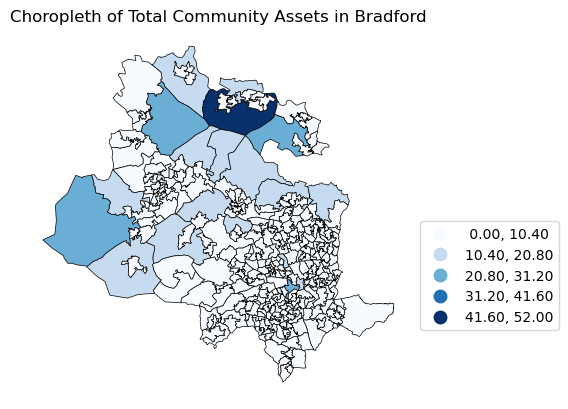

In [44]:
CreateChoro(Bradford_ratio,'Total Community Assets', 'Blues')

In [40]:
Bradford_ratio.iloc[:, 2:-1] = Bradford_ratio.iloc[:, 2:-1].astype(float)

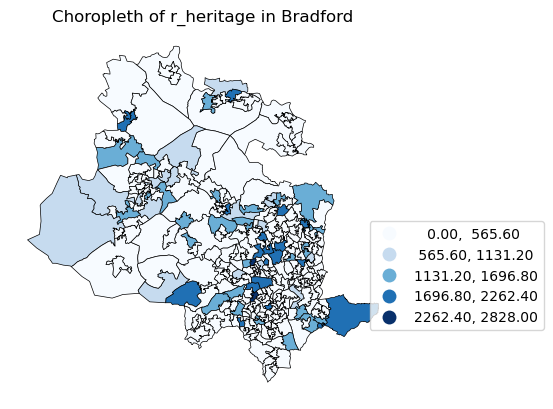

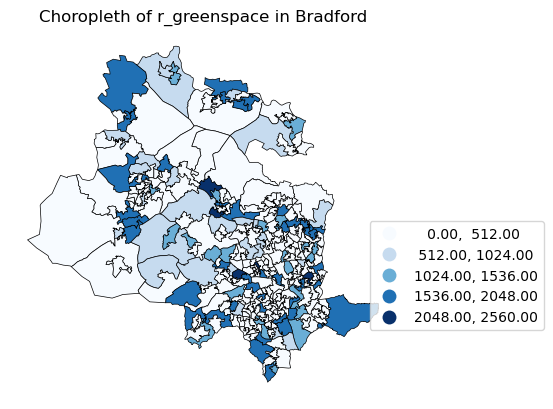

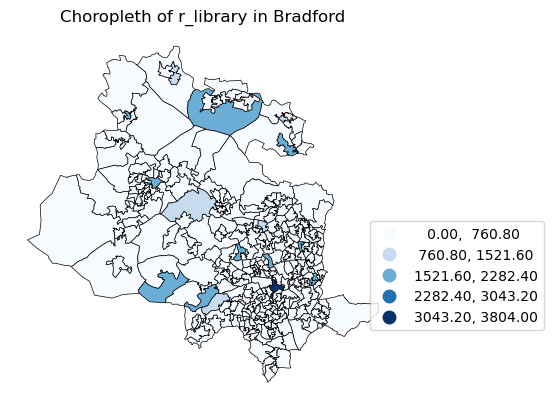

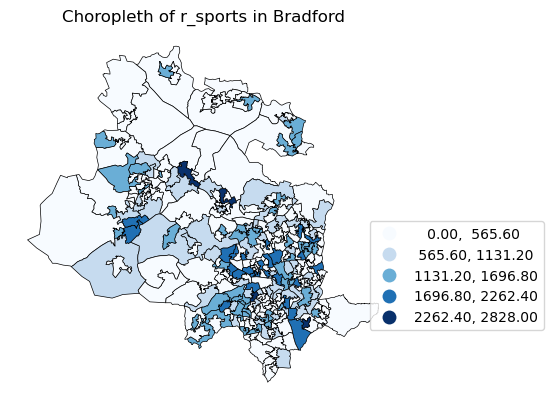

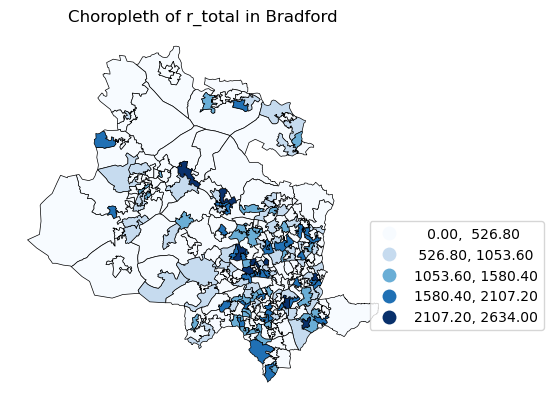

In [41]:
CreateChoro(Bradford_ratio,'r_heritage', 'Blues')
CreateChoro(Bradford_ratio,'r_greenspace', 'Blues')
CreateChoro(Bradford_ratio,'r_library', 'Blues')
CreateChoro(Bradford_ratio,'r_sports', 'Blues')
CreateChoro(Bradford_ratio,'r_total', 'Blues')

In [43]:
c = Bradford_ratio.corr()
c.iloc[[12], 15:]

,Heritage,Greenspace,Library,Sport Centers,Total Community Assets,r_heritage,r_greenspace,r_library,r_sports,r_total
Health_Score,-0.128822,-0.200584,-0.008088,-0.240631,-0.234037,-0.115303,-0.090388,0.043475,0.027698,0.025125
